# Restricted Boltzmann Machines

Baseado em: https://blog.paperspace.com/beginners-guide-to-boltzmann-machines-pytorch/


Boltzmann Machine pode ser considerada uma juncao entre os campos de deep learning e fisica, e pode ser muito util para reducao de dimensionalidade, classificacao, regressao, filtragem colaborative, etc. 

## Trabalhando com Maquinas de Boltzmann

As maquinas de Boltzmann sao inspiradas na distribuicao de Boltzmann, a qual diz que o estado do sistema depende de sua energia e da temperatura em que esta operando, por isso, dizemos que o modelo e baseado em energia. O termo energia aqui e equivalente ao desvio da saida esperada. Quanto maior a energia, maior e o desvio. Sendo assim, o modelo e treinado com o objetivo de minimizar essa energia. 

<img src='assets/bm.png' width=800px>

## A intuicao por traz das maquinas de Boltzmann

As maquinas de Boltzmann tem uma arquitetura diferente das demais redes neurais. Nao existe uma demarcacao clara entre camada de entrada e de saida. Na verdade, nao tem camada de saida. Os nos em uma maquina de Boltzmann sao categorizados apenas como visiveis ou escondidos. Os nos visiveis recebem os dados de entrada, e sao reconstruidos como sendo os nos de saida. 

Na versao original da maquina de Boltzmann, todos os nos sao conectados, sejam eles das camadas visivel ou invisivel, e todas as conexoes sao bi-direcionais.

<img src='assets/bmGraph.png' width=600px>

Alem disso, cada no pode assumir apenas dois estados possiveis, ligado ou desligado. O estado de um no e determinado pelos pesos e bias associados a ele. 

## Tipos de maquinas de Boltzmann

Existem diversas variacoes de Maquinas de Boltzmann que evoluiram com o tempo para resolver diversos tipos de problemas. Entre as mais conhecidas, podemos citar a Maquina de Boltzmann Restrita ( _Restricted Boltzmann Machine - RBM_ ), Maquina de Crenca Profunda ( _Deep Belief Network - DBN_ ) e a Maquina de Boltzmann Profunda ( _Deep Boltzmann Machine - DBM_ ). 

### Restricted Boltzmann Machines

O maior problema da maquina de Boltzmann convencional e a enorme quantidade de calculos a serem executados mesmo para uma pequena quantidade de dados. Nesses casos, atualizar os pesos da rede se torna uma tarefa muito demorada devido as dependencias entre os nos. Para reduzir essa dependencia, uma restricao foi imposta ao modelo para remover as conexoes intra-camadas. 

<img src='assets/bm_rbm.png' width=600px>

Essa restricao imposta as conexoes tornam as unidades de entrada e os nos esondidos independentes dentro de suas camadas. Sendo assim, os pesos podem ser atualizados em paralelo.

<img src='assets/rbmCon.png' width=600px>

### Deep Belief Network e Deep Boltzmann Machines

Deep Belief Network e Deep Boltzmann Machines sao versoes empilhadas da RBM, criando modelos em profundidade. DBNs sao inicializadas aleatoriamente e utilizam cadeias de Markov para definir a ocorrencia de possiveis eventos, que sao ajustados durante o processo de treinamento. O processo e lento, e as DBMs tentam oferecer uma solucao mais pratica com um treinamento mais refinado.

<img src='assets/dbn_dbm.png' width=600px>

Apesar das duas arquiteturas serem confundidas frequentemente, a diferenca pode ser notada nas conexoes. As conexoes da DBN nas camadas superiores tem uma unica direcao, enquanto nas DBMs sao bi-direcionais.

## Implementando RBMs com PyTorch


Vamos implementar a RBM em PyTorch para reconstrucao de digitos usando o dataset MNIST.

### Passo 1: Importando os pacotes necessarios

Nesse passo, importamos todos os pacotes. Note que usaremos `torchvision.utils` para visualizacao dos resultados.

In [1]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
%matplotlib inline
import matplotlib.pyplot as plt

### Passo 2: Carregando o dataset MNIST

Esse passo carrega o conjunto de treinamento e teste do dataset MNIST usando a classe Dataloader do pacote `torch.utils.data`. Vamos utilizar um batch de tamanho 64 e aplicar as transformacoes necessarias.


In [4]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
datasets.MNIST('./data',
    train=True,
    download = True,
    transform = transforms.Compose(
        [transforms.ToTensor()])
     ),
     batch_size=batch_size
)

test_loader = torch.utils.data.DataLoader(
datasets.MNIST('./data',
    train=False,
    transform=transforms.Compose(
    [transforms.ToTensor()])
    ),
    batch_size=batch_size)

### Passo 3: Definindo o modelo

Nesse passo, comecaremos a construir nosso modelo. Vamos definir as transformacoes associadas com os neuronios visiveis e escondidos. Alem disso, pela RBM ser um modelo baseado em energia, vamos tambem definir uma funcao para computar a diferenca de energia. Na inicializacao da funcao, tambem inicializaremos os pesos e os bias para os neuronios visiveis e escondidos.

In [5]:
class RBM(nn.Module):
    def __init__(self,
               n_vis=784,
               n_hin=500,
               k=5):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hin,n_vis)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hin))
        self.k = k
    
    def sample_from_p(self,p):
        return F.relu(torch.sign(p - Variable(torch.rand(p.size()))))
    
    def v_to_h(self,v):
        p_h = torch.sigmoid(F.linear(v,self.W,self.h_bias))
        sample_h = self.sample_from_p(p_h)
        return p_h,sample_h
    
    def h_to_v(self,h):
        p_v = torch.sigmoid(F.linear(h,self.W.t(),self.v_bias))
        sample_v = self.sample_from_p(p_v)
        return p_v,sample_v
        
    def forward(self,v):
        pre_h1,h1 = self.v_to_h(v)
        
        h_ = h1
        for _ in range(self.k):
            pre_v_,v_ = self.h_to_v(h_)
            pre_h_,h_ = self.v_to_h(v_)
        
        return v,v_
    
    def free_energy(self,v):
        vbias_term = v.mv(self.v_bias)
        wx_b = F.linear(v,self.W,self.h_bias)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()


Sempre precisamos definir o metodo forward, o qual e usado pela rede para propagar os pesos e os bias pela rede e computar todos os valores. O processo e repetido por $k$ vezes, o que define o numero de vezes em que computamos a divergencia constrastiva. Uma vez que as RBMs sao modelos baseados em energia, no fim definimos um metodo que calcula a energia do modelo.


### Passo 4: Inicializando e treinando o modelo

A classe da RBM que criamos e inicializada com $k=1$. Vamos usar o otimizador SGD no exemplo. No fim do processo, todas os custos sao acumulados em um vetor 1D. Extrairemos a distribuicao de Bernoulli usando o metodo `data.bernoulli()`. Esse e o padrao de entrada com o qual comecaremos.

Uma amostra de entrada e usada para alimentar a RBM, a qual retorna o padrao reconstruido como saida. O erro e calculado como a diferenca entre as energias desses dois padroes e adicionada em uma lista. O erro e propagado usando o metodo `backward()`. Ja o metodo `optimizer.step()` executa a atualizacao dos parametros baseando-se no gradiente acumulado, armazenado no atributo `.grad`, executando a atualizacao de todos os parametros.

In [6]:
rbm = RBM(k=1)
train_op = optim.SGD(rbm.parameters(),0.1)

for epoch in range(10):
    loss_ = []
    for _, (data,target) in enumerate(train_loader):
        data = Variable(data.view(-1,784))
        sample_data = data.bernoulli()
        
        v,v1 = rbm(sample_data)
        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        loss_.append(loss.data)
        train_op.zero_grad()
        loss.backward()
        train_op.step()

    print("Training loss for {} epoch: {}".format(epoch, np.mean(loss_)))


Training loss for 0 epoch: -8.378804206848145
Training loss for 1 epoch: -6.64418888092041
Training loss for 2 epoch: -4.56675910949707
Training loss for 3 epoch: -3.1676511764526367
Training loss for 4 epoch: -2.252711534500122
Training loss for 5 epoch: -1.5957361459732056
Training loss for 6 epoch: -1.0273723602294922
Training loss for 7 epoch: -0.6958441734313965
Training loss for 8 epoch: -0.5142412185668945
Training loss for 9 epoch: -0.25620394945144653


Na sequencia, definimos uma funcao auxiliar para transpor a imagem para uma dimensao apropriada e armazena-la.

In [7]:
def show_adn_save(file_name,img):
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "./%s.png" % file_name
    plt.imshow(npimg)
    plt.imsave(f,npimg)

### Passo 5: visualizando as saidas

Nesse passo, vamos visualizar as saidas

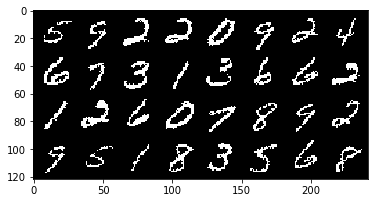

In [8]:
show_adn_save("real",make_grid(v.view(32,1,28,28).data))

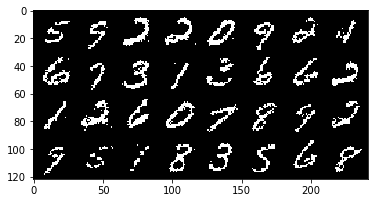

In [9]:
show_adn_save("geradas",make_grid(v1.view(32,1,28,28).data))

Como podemos ver, na imagem de cima temos as imagens reais de amostras do dataset MNIST, enquanto a imagem de baixo apresenta as amostras geradas pela RBM.

# Exercicios